# Pipeline
* Take videos
* Sample at 1 fps
* Extract KAZE descriptors

* For input take a subsample of a video
* Sample at 1 fps
* Extract KAZE descriptors
* Make matrix of KAZE descriptors
* Find all candidates for sequence start
    * Extract matrices of KAZE descriptors
    * Find matrix with min cosine distance

In [1]:
import cv2
import numpy as np
import pandas as pd
import scipy
from scipy.misc import imread
import cPickle as pickle
import random
import os
import matplotlib.pyplot as plt
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from moviepy.editor import VideoFileClip
import shutil
%matplotlib inline

In [2]:
def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()

In [3]:
cv2.__version__

'3.4.2'

In [52]:
FRAMES_MOD = 20
video_folder = '../data'
frame_dir_path = './frames'
tmp_dir_path = './tmp'

if os.path.exists(frame_dir_path):
    shutil.rmtree(frame_dir_path)
os.makedirs(frame_dir_path)
    
if os.path.exists(tmp_dir_path):
    shutil.rmtree(tmp_dir_path)
os.makedirs(tmp_dir_path)

In [100]:
def video_to_frames(vpath, frames_dir, frames_mod):
    vid = cv2.VideoCapture(vpath)
    video_name = os.path.basename(vpath)
    print 'Sampling video %s' % vpath

    width = int(vid.get(3))   # float
    height = int(vid.get(4)) # float

    index = 0
    while(True):
        # Extract images
        ret, frame = vid.read()
        # end of frames
        if not ret: 
            break

        if index % frames_mod == 0:
            fpath = os.path.join(frames_dir, '{}_{}.jpg'.format(video_name, str(index)))
            frame = frame.astype('uint8')
            cv2.imwrite(fpath, frame)
        index += 1
    vid.release()
    
def videos_to_frames(dirpath, frames_dir, frames_mod=10):
    fpaths = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
    for fpath in fpaths:
        video_to_frames(fpath, frames_dir, frames_mod)

def extract_img_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")

    # Using KAZE, cause SIFT, ORB and other was moved to additional module
    # which is adding addtional pain during install
    alg = cv2.ORB_create()
    # Dinding image keypoints
    kps = alg.detect(image)
    # Getting first 32 of them. 
    # Number of keypoints is varies depend on image size and color pallet
    # Sorting them based on keypoint response value(bigger is better)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    # computing descriptors vector
    kps, dsc = alg.compute(image, kps)
    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (vector_size * 64)
    # Flatten all of them in one big vector - our feature vector
    dsc = dsc.flatten() if dsc is not None else np.zeros(needed_size)
    if dsc.size < needed_size:
        # if we have less the 32 descriptors then just adding zeros at the
        # end of our feature vector
        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    #except cv2.error as e:
    #    print 'Error: ', e
    #    return None

    return dsc

def get_frames_descriptors(dirpath):
    fpaths = [os.path.join(dirpath, fname) for fname in os.listdir(dirpath)]
    
    descriptors = []#pd.DataFrame(columns=['descriptor', 'video_name', 'index'])
    for fpath in fpaths:
        #print 'Processing image %s' % fpath
        fname = os.path.basename(fpath)
        name_components = fname.split('_')
        video_name = '_'.join(name_components[:-1])
        index = int(name_components[-1].split('.')[0])
        descriptor = extract_img_features(fpath)
        descriptors.append({
            'descriptor': descriptor,
            'video_name': video_name,
            'frame_img_path': fpath,
            'index': index
        })
    descriptors = pd.DataFrame.from_dict(descriptors).sort_values(by=['video_name', 'index']).reset_index(drop=True)
    return descriptors

In [101]:
videos_to_frames(video_folder, frame_dir_path, FRAMES_MOD)

Sampling video ../data/byvshye_s01_ep01_eg01_____2018-05-30.mp4
Sampling video ../data/v_854x480__c_hevc.mp4
Sampling video ../data/indi114.mpg


In [102]:
%%time
descriptors = get_frames_descriptors(frame_dir_path)

CPU times: user 901 ms, sys: 67.9 ms, total: 969 ms
Wall time: 739 ms


In [103]:
descriptors.head()

,descriptor,frame_img_path,index,video_name
0,"[53.0, 249.0, 16.0, 126.0, 89.0, 157.0, 86.0, ...",./frames/byvshye_s01_ep01_eg01_____2018-05-30....,0,byvshye_s01_ep01_eg01_____2018-05-30.mp4
1,"[229.0, 101.0, 157.0, 103.0, 164.0, 14.0, 70.0...",./frames/byvshye_s01_ep01_eg01_____2018-05-30....,20,byvshye_s01_ep01_eg01_____2018-05-30.mp4
2,"[126.0, 98.0, 164.0, 165.0, 172.0, 39.0, 140.0...",./frames/byvshye_s01_ep01_eg01_____2018-05-30....,40,byvshye_s01_ep01_eg01_____2018-05-30.mp4
3,"[106.0, 186.0, 144.0, 50.0, 169.0, 137.0, 16.0...",./frames/byvshye_s01_ep01_eg01_____2018-05-30....,60,byvshye_s01_ep01_eg01_____2018-05-30.mp4
4,"[64.0, 186.0, 151.0, 26.0, 9.0, 193.0, 128.0, ...",./frames/byvshye_s01_ep01_eg01_____2018-05-30....,80,byvshye_s01_ep01_eg01_____2018-05-30.mp4


In [104]:
# create test video - pick a random video from train ones and cut out 10% of it.
fnames = os.listdir(video_folder)
test_video = random.sample(fnames, 1)[0]
test_fpath = os.path.join(video_folder, test_video)
subclip_fname = os.path.join(tmp_dir_path, 'subclip_'+test_video)
test_video
clip = VideoFileClip(test_fpath)
duration = clip.duration
subclip_duration = max(5, int(duration*0.1))
subclip_start_time = np.random.randint(0, duration-subclip_duration)
print 'Cutting %d - %d' % (subclip_start_time, subclip_start_time+subclip_duration)
ffmpeg_extract_subclip(test_fpath, subclip_start_time, subclip_start_time+subclip_duration, targetname=subclip_fname)

Cutting 23 - 29
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [105]:
# cut subclip frames
subclib_frames_dir = os.path.join(tmp_dir_path, 'frames_{}'.format(test_video))
if os.path.exists(subclib_frames_dir):
    shutil.rmtree(subclib_frames_dir)
os.makedirs(subclib_frames_dir)
video_to_frames(subclip_fname, subclib_frames_dir, FRAMES_MOD)

Sampling video ./tmp/subclip_indi114.mpg


In [106]:
subclip_descriptors = get_frames_descriptors(subclib_frames_dir)
subclip_descriptors

,descriptor,frame_img_path,index,video_name
0,"[22.0, 179.0, 0.0, 174.0, 59.0, 133.0, 154.0, ...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_0...,0,subclip_indi114.mpg
1,"[62.0, 235.0, 232.0, 110.0, 125.0, 91.0, 222.0...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_2...,20,subclip_indi114.mpg
2,"[51.0, 51.0, 82.0, 0.0, 91.0, 179.0, 184.0, 70...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_4...,40,subclip_indi114.mpg
3,"[122.0, 109.0, 111.0, 36.0, 78.0, 210.0, 238.0...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_6...,60,subclip_indi114.mpg
4,"[110.0, 249.0, 224.0, 225.0, 253.0, 93.0, 222....",./tmp/frames_indi114.mpg/subclip_indi114.mpg_8...,80,subclip_indi114.mpg
5,"[126.0, 249.0, 114.0, 238.0, 127.0, 149.0, 90....",./tmp/frames_indi114.mpg/subclip_indi114.mpg_1...,100,subclip_indi114.mpg
6,"[46.0, 249.0, 224.0, 225.0, 189.0, 205.0, 222....",./tmp/frames_indi114.mpg/subclip_indi114.mpg_1...,120,subclip_indi114.mpg
7,"[15.0, 183.0, 96.0, 67.0, 245.0, 157.0, 250.0,...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_1...,140,subclip_indi114.mpg
8,"[215.0, 69.0, 199.0, 164.0, 164.0, 50.0, 110.0...",./tmp/frames_indi114.mpg/subclip_indi114.mpg_1...,160,subclip_indi114.mpg


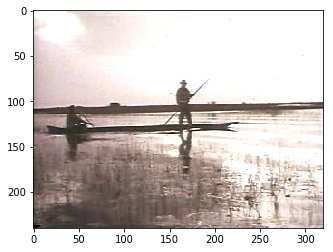

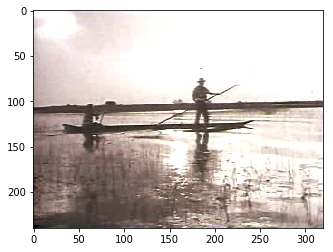

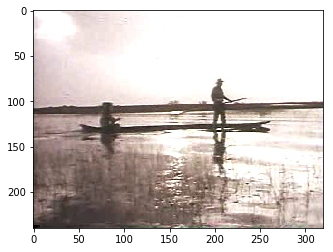

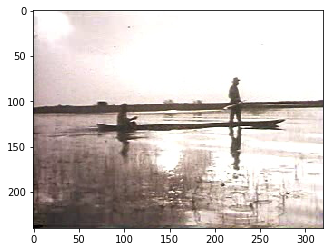

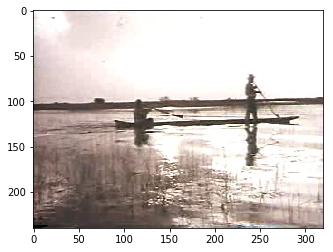

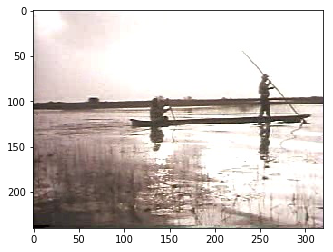

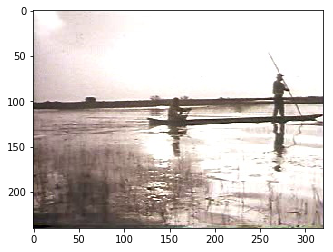

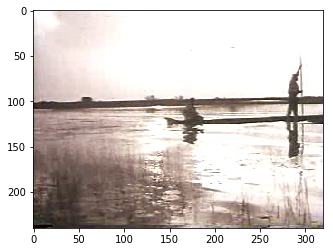

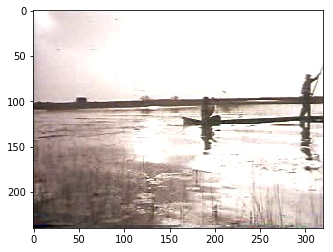

In [107]:
for i in range(len(subclip_descriptors)):
    frame = subclip_descriptors.ix[i]
    show_img(frame.frame_img_path)

In [110]:
query_descriptor_index = 0

In [111]:
# first frame descriptor
query_descriptor = subclip_descriptors.loc[query_descriptor_index].descriptor
query_descriptor

array([ 22., 179.,   0., ...,   0.,   0.,   0.])

In [112]:
# matrix of descriptors
descriptor_matrix = np.stack(subclip_descriptors.descriptor.values)
descriptor_matrix.shape
descriptor_matrix

array([[ 22., 179.,   0., ...,   0.,   0.,   0.],
       [ 62., 235., 232., ...,   0.,   0.,   0.],
       [ 51.,  51.,  82., ...,   0.,   0.,   0.],
       ...,
       [ 46., 249., 224., ...,   0.,   0.,   0.],
       [ 15., 183.,  96., ...,   0.,   0.,   0.],
       [215.,  69., 199., ...,   0.,   0.,   0.]])

In [113]:
scipy.spatial.distance.cosine(descriptors.loc[1].descriptor, query_descriptor)

0.48139691344652347

In [114]:
desc_ids = descriptors.frame_img_path
desc_video_ids = descriptors.video_name
desc_vectors = np.array([np.array(v) for v in descriptors.descriptor.values]) #[np.array(x) for x in descriptors.descriptor.values]

In [115]:
distances_to_first_vector = scipy.spatial.distance.cdist(desc_vectors, [query_descriptor], metric='cosine')
dist_flat = distances_to_first_vector.flatten()
dist_flat[np.isnan(dist_flat)] = np.inf
sorted_order = np.argsort(dist_flat)
dist_flat_sorted = dist_flat[sorted_order]
desc_ids_sorted = desc_ids[sorted_order]
desc_video_ids_sorted = desc_video_ids[sorted_order]
desc_index_sorted = descriptors.index[sorted_order]
print(dist_flat_sorted[:5])
print(desc_ids_sorted[:5])
print(desc_video_ids_sorted[:5])

[0.17266864 0.17329339 0.1787124  0.17932309 0.17990566]
81    ./frames/indi114.mpg_1420.jpg
80    ./frames/indi114.mpg_1400.jpg
78    ./frames/indi114.mpg_1360.jpg
97    ./frames/indi114.mpg_1740.jpg
13      ./frames/indi114.mpg_60.jpg
Name: frame_img_path, dtype: object
81    indi114.mpg
80    indi114.mpg
78    indi114.mpg
97    indi114.mpg
13    indi114.mpg
Name: video_name, dtype: object


In [116]:
desc_index_sorted[:5]

Int64Index([81, 80, 78, 97, 13], dtype='int64')

Query image
./tmp/frames_indi114.mpg/subclip_indi114.mpg_0.jpg


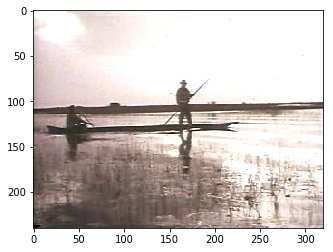

In [117]:
print('Query image')
print(subclip_descriptors.loc[query_descriptor_index].frame_img_path)
show_img(subclip_descriptors.loc[query_descriptor_index].frame_img_path)

Top 5 closest frames in database
(0.17266864184925568, './frames/indi114.mpg_1420.jpg')


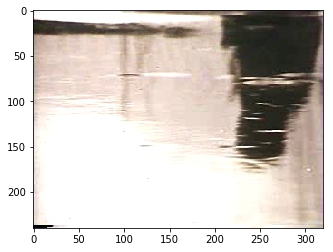

(0.17329339312401681, './frames/indi114.mpg_1400.jpg')


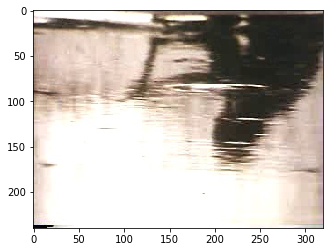

(0.178712403038354, './frames/indi114.mpg_1360.jpg')


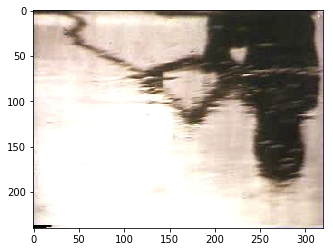

(0.17932309229806886, './frames/indi114.mpg_1740.jpg')


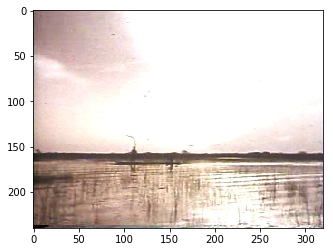

(0.1799056604559066, './frames/indi114.mpg_60.jpg')


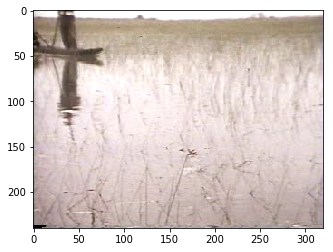

In [118]:
print('Top 5 closest frames in database')
for dist, img_path in zip(dist_flat_sorted[:5], desc_ids_sorted[:5]):
    print(dist, img_path)
    show_img(img_path)

Top similar frames for each video
['byvshye_s01_ep01_eg01_____2018-05-30.mp4' 'indi114.mpg'
 'v_854x480__c_hevc.mp4']
0      byvshye_s01_ep01_eg01_____2018-05-30.mp4
81                                  indi114.mpg
106                       v_854x480__c_hevc.mp4
Name: video_name, dtype: object
Vidname byvshye_s01_ep01_eg01_____2018-05-30.mp4
Score 0.21950851718839703
Path ./frames/byvshye_s01_ep01_eg01_____2018-05-30.mp4_0.jpg


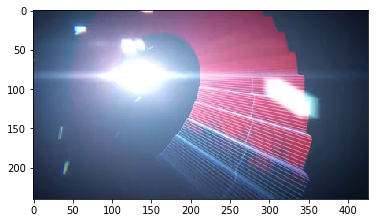

Vidname indi114.mpg
Score 0.17266864184925568
Path ./frames/indi114.mpg_1420.jpg


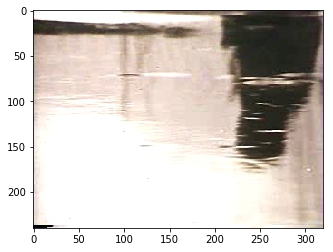

Vidname v_854x480__c_hevc.mp4
Score 0.1871175481084819
Path ./frames/v_854x480__c_hevc.mp4_100.jpg


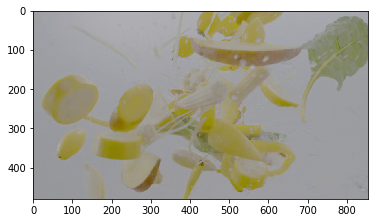

In [119]:
print('Top similar frames for each video')
vidnames, top_index = np.unique(desc_video_ids_sorted, return_index=True)
print(vidnames)
print(desc_video_ids_sorted.iloc[top_index])
for i in top_index:
    print 'Vidname', desc_video_ids_sorted.iloc[i]
    print 'Score', dist_flat_sorted[i]
    print 'Path', desc_ids_sorted.iloc[i]
    show_img(desc_ids_sorted.iloc[i])

In [120]:
# Take the location of the closest frame to the query subclip frame
# Get frames that follow
subclip_frames = len(subclip_descriptors)
closest_frame = descriptors.ix[desc_index_sorted[0]]
frame_index = closest_frame.name
following_frames = descriptors.ix[frame_index:frame_index+subclip_frames-query_descriptor_index-1]
following_frames = following_frames[following_frames.video_name == closest_frame.video_name]

# Pairwise compare distances
subclip_following_frames = subclip_descriptors[query_descriptor_index:]
#
comparison = []
for i in range(len(following_frames)):
    frame = following_frames.iloc[i]
    subclip_frame = subclip_following_frames.iloc[i]
    #print(frame)
    #print(subclip_frame)
    
    dist = scipy.spatial.distance.cosine(subclip_frame.descriptor, frame.descriptor)
    comparison.append(
        {
            'train_frame_idx': frame.name,
            'test_frame_idx': subclip_following_frames.iloc[i].name,
            'dist': dist
        }
    )
comparison = pd.DataFrame(comparison)

0.17266864184925568


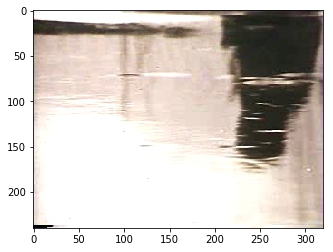

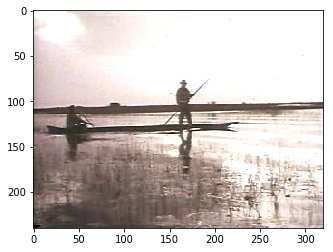

0.19175097755266368


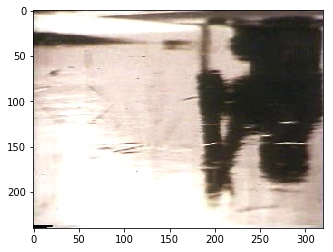

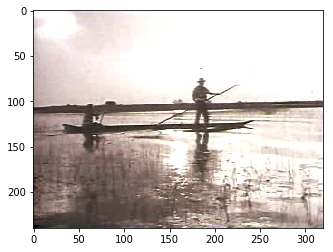

0.20299877202904149


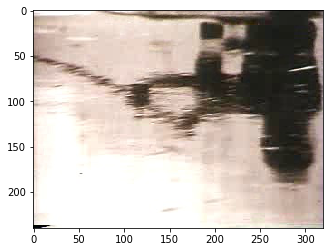

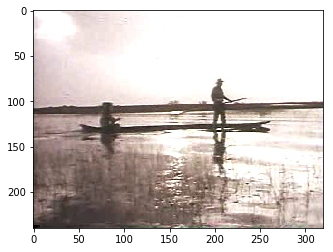

0.23518056663938736


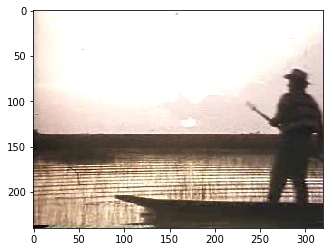

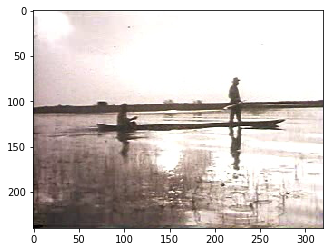

0.21575719855815312


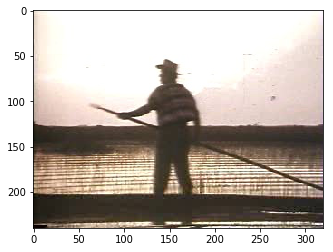

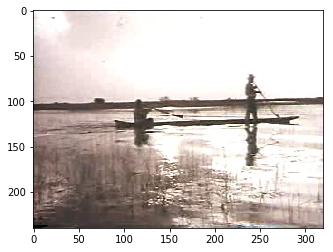

0.20937901205867326


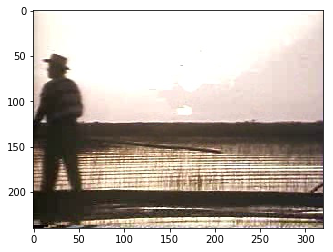

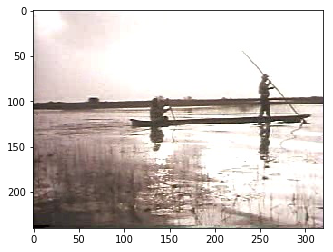

0.24262941682718064


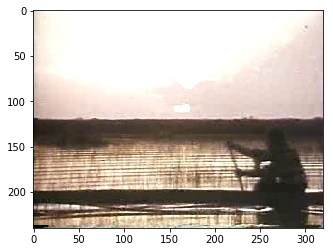

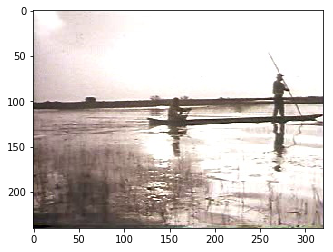

0.21748583559947332


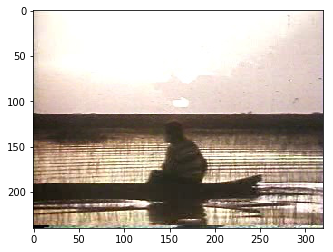

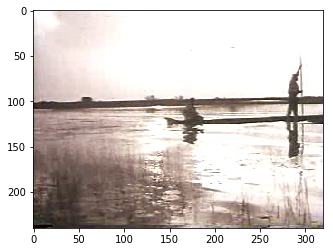

0.23425231647616396


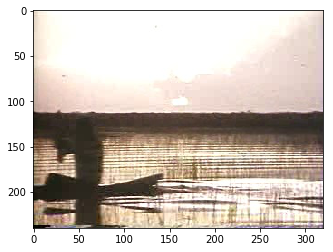

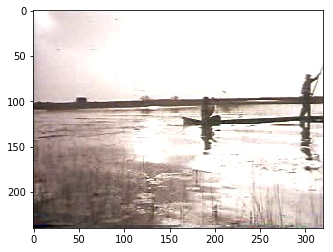

In [121]:
for i in range(len(comparison)):
    train_frame = descriptors.ix[comparison.iloc[i].train_frame_idx]
    test_frame =  subclip_descriptors.ix[comparison.iloc[i].test_frame_idx]
    dist = comparison.iloc[i].dist
    print(dist)
    show_img(train_frame.frame_img_path)
    show_img(test_frame.frame_img_path)
    print('=======')

In [122]:
print('How to draw verdict?')
print('l2 norm', np.linalg.norm(comparison.dist.dropna()))
print('mean', comparison.dist.mean())

How to draw verdict?
('l2 norm', 0.6438441639338411)
('mean', 0.21356697084333248)


In [123]:
print('Alternative: compare matrices')

Alternative: compare matrices


In [124]:
following_frames_matrix = np.stack(following_frames.descriptor.values)
following_frames_matrix

array([[251., 208., 226., ...,   0.,   0.,   0.],
       [ 78., 165., 112., ...,   0.,   0.,   0.],
       [ 30.,  62., 255., ...,   0.,   0.,   0.],
       ...,
       [ 76.,  60., 191., ...,   0.,   0.,   0.],
       [130., 172.,  62., ...,   0.,   0.,   0.],
       [ 72., 189., 187., ...,   0.,   0.,   0.]])

In [125]:
subclip_following_frames_matrix = np.stack(subclip_following_frames.descriptor.values)
subclip_following_frames_matrix

array([[ 22., 179.,   0., ...,   0.,   0.,   0.],
       [ 62., 235., 232., ...,   0.,   0.,   0.],
       [ 51.,  51.,  82., ...,   0.,   0.,   0.],
       ...,
       [ 46., 249., 224., ...,   0.,   0.,   0.],
       [ 15., 183.,  96., ...,   0.,   0.,   0.],
       [215.,  69., 199., ...,   0.,   0.,   0.]])

In [126]:
def norm_2(m1, m2):
    return np.sqrt(np.sum(np.sum(np.square(m1-m2))))
norm_2(subclip_following_frames_matrix, following_frames_matrix)

10104.663576784731

In [127]:
subclip_frames

9

In [128]:
random_index = descriptors.iloc[:len(descriptors)-subclip_frames-query_descriptor_index-1].sample().iloc[0].name

In [129]:
# random_matrix
random_frames = descriptors.ix[random_index:random_index+subclip_frames-query_descriptor_index-1]
random_frames

,descriptor,frame_img_path,index,video_name
23,"[63.0, 25.0, 164.0, 99.0, 205.0, 95.0, 219.0, ...",./frames/indi114.mpg_260.jpg,260,indi114.mpg
24,"[83.0, 183.0, 67.0, 165.0, 50.0, 190.0, 106.0,...",./frames/indi114.mpg_280.jpg,280,indi114.mpg
25,"[221.0, 34.0, 124.0, 97.0, 160.0, 63.0, 120.0,...",./frames/indi114.mpg_300.jpg,300,indi114.mpg
26,"[71.0, 251.0, 153.0, 5.0, 178.0, 140.0, 47.0, ...",./frames/indi114.mpg_320.jpg,320,indi114.mpg
27,"[135.0, 76.0, 167.0, 153.0, 172.0, 18.0, 239.0...",./frames/indi114.mpg_340.jpg,340,indi114.mpg
28,"[217.0, 122.0, 60.0, 181.0, 40.0, 109.0, 81.0,...",./frames/indi114.mpg_360.jpg,360,indi114.mpg
29,"[93.0, 115.0, 123.0, 230.0, 53.0, 13.0, 95.0, ...",./frames/indi114.mpg_380.jpg,380,indi114.mpg
30,"[76.0, 166.0, 146.0, 113.0, 240.0, 174.0, 96.0...",./frames/indi114.mpg_400.jpg,400,indi114.mpg
31,"[216.0, 73.0, 174.0, 188.0, 141.0, 214.0, 95.0...",./frames/indi114.mpg_420.jpg,420,indi114.mpg


In [130]:
random_frames_matrix = np.stack(random_frames.descriptor.values)
norm_2(subclip_following_frames_matrix, random_frames_matrix)

9827.7599685788

In [131]:
# Matrix norm == crap results

In [132]:
comparison = []
for i in range(len(random_frames)):
    frame = random_frames.iloc[i]
    subclip_frame = subclip_following_frames.iloc[i]
    
    dist = scipy.spatial.distance.cosine(subclip_frame.descriptor, frame.descriptor)
    comparison.append(
        {
            'train_frame_idx': frame.name,
            'test_frame_idx': subclip_following_frames.iloc[i].name,
            'dist': dist
        }
    )
comparison = pd.DataFrame(comparison)
print(comparison)
print('l2 norm', np.linalg.norm(comparison.dist))
print('mean', comparison.dist.mean())

       dist  test_frame_idx  train_frame_idx
0  0.217772               0               23
1  0.219328               1               24
2  0.218864               2               25
3  0.224907               3               26
4  0.208756               4               27
5  0.234546               5               28
6  0.203220               6               29
7  0.204934               7               30
8  0.224290               8               31
('l2 norm', 0.6528455721483635)
('mean', 0.2174019115178905)


In [99]:
# Comparing mean with random subsequence vs actual subsequence: about 0.15 difference
# L2 norm is much more sensible, it seems. About 0.6 diff.